## Настройки ClickHouse

In [63]:
import utils
import pandas as pd
from utils import simple_ch_client


CH_HOST_NAME = 'rc1c-dp4f585c5tk96k9m.mdb.yandexcloud.net'
CH_USER      = 'firstsvet02'
CH_DB_NAME   = 'AppMetrica_workshop'

#-------------------------------------------
CH_PASS      = open('chpass.txt').read().strip()
CH_HOST      = f'https://{CH_HOST_NAME}:8443'
CH_CASERT    = 'certificate/YandexInternalRootCA.crt'

In [64]:
my_client = simple_ch_client(CH_HOST, CH_USER, CH_PASS, CH_CASERT)

/kernel/lib/python3.7/site-packages/ml_kernel/ignored_keyboard_interrupt.py:16: UserWarning: Kernel cannot be interrupted during state load
  warnings.warn(self._warn_message)


## Агрегируем данные в последовательность пользовательских визитов

In [65]:
import pandas as pd
import requests
import json

In [76]:
q = f'''
SELECT
    appmetrica_device_id,
    num_steps,
    arrayStringConcat(filt_events, ' -> ') as events_seq
FROM
    (SELECT
        appmetrica_device_id,
        groupArray(event_name) as events,
        count(event_name) as cnt_events,
        groupArray(datetime) as times,
        arrayEnumerate(events) as indexes,
        arrayDifference(arrayMap(x -> toUInt64(x), times)) as times_diffs,
        arrayFilter(e, i -> (i = 1) or (events[i - 1] != events[i]) or (times_diffs[i] >= 1800),
                    events, indexes) as filt_events,
        length(filt_events) as num_steps
    FROM 
        (SELECT
            appmetrica_device_id,
            datetime,
            event_name
        FROM {CH_DB_NAME}.raw_appmetrica_auto_data
        ORDER BY appmetrica_device_id,
            datetime)
    GROUP BY appmetrica_device_id
    HAVING cnt_events <= 30)
format TSVWithNames
'''

stat_df = my_client.get_clickhouse_df(q)

In [77]:
stat_df.head()

,appmetrica_device_id,num_steps,events_seq
0,3985251952290244608,21,Просмотр -> Просмотр -> Сообщение -> Просмотр ...
1,4388665923296595968,7,Поиск -> Сниппет -> Поиск -> Сниппет -> Просмо...
2,18426457627675836416,17,Просмотр -> Сообщение -> Просмотр -> Поиск -> ...
3,8512777489338945536,6,Просмотр -> Поиск -> Сниппет -> Поиск -> Снипп...
4,13687251828939507712,7,Просмотр -> Поиск -> Сниппет -> Поиск -> Просм...


#### Посмотрим на распределение числа событий

array([[<AxesSubplot:title={'center':'num_steps'}>]], dtype=object)

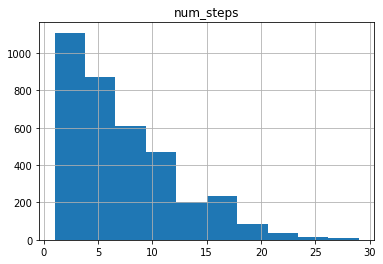

In [79]:
stat_df[['num_steps']].hist()

## Загрузка последовательностей пользовательских событий в CH

In [80]:
q = f'drop table if exists {CH_DB_NAME}.user_events_sequence'
my_client.get_clickhouse_data(q)

q = f'''
create table {CH_DB_NAME}.user_events_sequence (
    appmetrica_device_id UInt64,
    num_steps UInt32,
    events_seq String
) ENGINE = MergeTree()
ORDER BY appmetrica_device_id'''

my_client.get_clickhouse_data(q)

''

In [81]:
my_client.upload(
    f'{CH_DB_NAME}.user_events_sequence',
    stat_df[['appmetrica_device_id', 'num_steps', 'events_seq']].to_csv(index = False, sep = '\t'))

''

# Sankey Diagram в plotly

Считываем данные. Нам нужен id пользователя и последовательность из нескольких его шагов (возьмем для простоты 7)

In [233]:
q = f'''
SELECT
    appmetrica_device_id,
    arrayElement(filt_events, 1) as  step_1,
    arrayElement(filt_events, 2) as  step_2,
    arrayElement(filt_events, 3) as  step_3,
    arrayElement(filt_events, 4) as  step_4,
    arrayElement(filt_events, 5) as  step_5,
    arrayElement(filt_events, 6) as  step_6,
    arrayElement(filt_events, 7) as  step_7
FROM
    (SELECT
        appmetrica_device_id,
        groupArray(event_name) as events,
        count(event_name) as cnt_events,
        groupArray(datetime) as times,
        arrayEnumerate(events) as indexes,
        arrayDifference(arrayMap(x -> toUInt64(x), times)) as times_diffs,
        arrayFilter(e, i -> (i = 1) or (events[i - 1] != events[i]) or (times_diffs[i] >= 1800),
                    events, indexes) as filt_events,
        arrayEnumerate(filt_events) AS steps
    FROM 
        (SELECT
            appmetrica_device_id,
            datetime,
            event_name
        FROM {CH_DB_NAME}.raw_appmetrica_auto_data
        ORDER BY appmetrica_device_id,
            datetime)
    GROUP BY appmetrica_device_id
    HAVING length(steps) <= 10)

format TSVWithNames
'''

cjm_df = my_client.get_clickhouse_df(q)

In [234]:
cjm_df['finish'] = 'finish'
cjm_df = cjm_df.fillna('finish')

Следующий скрипт позволит выбросить редкие последовательности из выборки

In [279]:
GLOBAL_STEPS = ['step_1', 'step_2', 'step_3', 'step_4',
       'step_5', 'step_6', 'step_7']
def restrict_data(df):
    total_df = df.groupby(GLOBAL_STEPS).count().reset_index()
    total_df = total_df[total_df['finish'] >= 10][GLOBAL_STEPS]
    print ('uniq sequences:', len(total_df))
    return total_df.set_index(GLOBAL_STEPS).join(df.set_index(GLOBAL_STEPS)).reset_index()

In [280]:
data = restrict_data(cjm_df)

uniq sequences: 42


Посмотрим на данные

In [281]:
print (len(data))
data.head()

1477


,step_1,step_2,step_3,step_4,step_5,step_6,step_7,appmetrica_device_id,finish
0,Звонок,finish,finish,finish,finish,finish,finish,9032227552839858176,finish
1,Звонок,finish,finish,finish,finish,finish,finish,17316980291642101760,finish
2,Звонок,finish,finish,finish,finish,finish,finish,7475112695879621632,finish
3,Звонок,finish,finish,finish,finish,finish,finish,9824599120646324224,finish
4,Звонок,finish,finish,finish,finish,finish,finish,2971283483116684800,finish


Соберем необходимые массивы для построения Sankey диаграммы

In [283]:
def get_sankey_data(df):
    steps = GLOBAL_STEPS.copy()
    steps.append('finish')
    label = list(df['step_1'].unique())
    label.append('finish')
    source = [] 
    target = []
    value = [] 

    for ind, step in enumerate(steps[:-1]):
        curr_df = df[['appmetrica_device_id', step, steps[ind + 1]]].drop_duplicates().groupby([step, steps[ind + 1]])\
            .count().reset_index()
        curr_df = curr_df[(curr_df[step] != 'finish') | (curr_df[steps[ind + 1]] != 'finish')]

        source.extend(list(map(lambda x: label.index(x), curr_df[step])))
        outgoing = list(filter(lambda x: x not in label, list(curr_df[steps[ind + 1]].unique())))
        label.extend(outgoing)

        target.extend(list(map(lambda x: label.index(x), curr_df[steps[ind + 1]])))
        value.extend(curr_df['appmetrica_device_id']) 

    return label, source, target, value

In [284]:
label, source, target, value = get_sankey_data(data)

Посмотрим на содержимое

In [287]:
print (label,'\n')
print (source,'\n')
print (target,'\n')
print (value,'\n')

['Звонок', 'Поиск', 'Просмотр', 'Сниппет', 'finish', 'Сообщение'] 

[0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 5, 5, 1, 1, 2, 2, 2, 2, 3, 3, 3, 0, 1, 2, 2, 2, 3, 3, 3, 1, 2, 2, 2, 3, 3, 3, 1, 2, 2, 3, 3, 3, 1, 2, 3] 

[4, 2, 4, 2, 3, 4, 0, 1, 2, 5, 4, 1, 2, 4, 1, 2, 4, 3, 4, 2, 3, 4, 1, 2, 4, 1, 4, 3, 4, 0, 1, 3, 4, 1, 2, 4, 3, 4, 1, 3, 4, 1, 2, 3, 4, 1, 3, 4, 1, 2, 3, 4, 3, 4, 1, 2, 4, 4, 4] 

[32, 11, 42, 25, 659, 263, 48, 231, 47, 30, 34, 14, 41, 27, 10, 11, 32, 213, 63, 12, 49, 175, 282, 202, 19, 11, 15, 288, 93, 18, 21, 93, 161, 24, 77, 18, 45, 27, 40, 10, 118, 116, 147, 156, 49, 15, 83, 10, 14, 31, 29, 11, 20, 78, 40, 121, 40, 121, 49] 



Рисуем нашу визуализацию

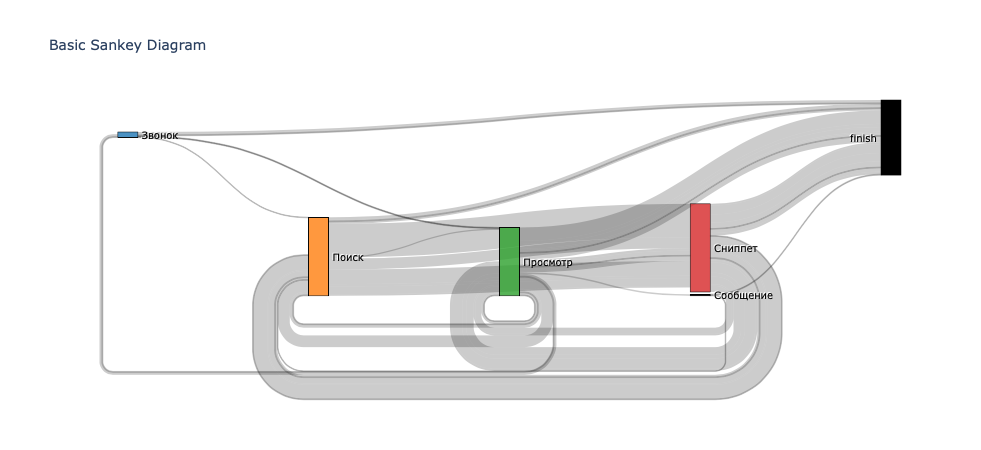

In [286]:
import plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = ['rgba(31, 119, 180, 0.8)', 'rgba(255, 127, 14, 0.8)', 'rgba(44, 160, 44, 0.8)', 'rgba(214, 39, 40, 0.8)']
    ),
    link = dict(
      source = source,
      target = target,
      value =  value
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()